In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 


In [11]:
data_1=pd.read_csv("./cleaned_data.csv")
data_1.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Unnamed: 16,Unnamed: 17
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15T02:18:49Z,2.0,0,January542024,202454March
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15T02:19:08Z,2.0,0,February33932024,202455March
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15T02:44:21Z,2.0,0,March552026,202554March
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15T03:32:55Z,2.0,0,April542027,202454March
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15T03:34:21Z,2.0,0,May542028,202554March


In [14]:
data_1["TransactionStartTime"]=pd.to_datetime(data_1["TransactionStartTime"])

In [18]:
RFMS=pd.DataFrame({})

In [19]:
most_recent_txn = data_1.groupby('AccountId')['TransactionStartTime'].max()
RFMS['Recency'] = data_1['AccountId'].map(lambda x: (data_1['TransactionStartTime'].max() - most_recent_txn[x]).days)

transaction_count = data_1.groupby('AccountId')['TransactionId'].count()
RFMS['Frequency'] = data_1['AccountId'].map(transaction_count)


RFMS['Monetary'] = data_1['Amount'].abs()


RFMS['FraudPenalty'] = data_1['FraudResult'].apply(lambda x: -100 if x == 1 else 0)

RFMS.head()



,Recency,Frequency,Monetary,FraudPenalty
0,5,66,1000.0,0
1,0,30895,3679.0,0
2,81,2,500.0,0
3,5,26,20000.0,0
4,0,30895,644.0,0


In [21]:
RFMS['RFMS_Score'] = (0.3 * RFMS['Recency'] +  
                    0.4 * RFMS['Frequency'] + 
                    0.4 * RFMS['Monetary'] + 
                    RFMS['FraudPenalty'])
RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score
0,5,66,1000.0,0,427.9
1,0,30895,3679.0,0,13829.6
2,81,2,500.0,0,225.1
3,5,26,20000.0,0,8011.9
4,0,30895,644.0,0,12615.6


In [22]:
threshold = RFMS['RFMS_Score'].median()

# Label each account as 'Good' or 'Bad'
RFMS['Risk'] = RFMS['RFMS_Score'].apply(lambda x: 'Good' if x >= threshold else 'Bad')

RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score,Risk
0,5,66,1000.0,0,427.9,Bad
1,0,30895,3679.0,0,13829.6,Good
2,81,2,500.0,0,225.1,Bad
3,5,26,20000.0,0,8011.9,Good
4,0,30895,644.0,0,12615.6,Good


In [36]:
risk_distribution = RFMS.groupby('RFMS_Bins')['Risk'].value_counts()
print(risk_distribution)

RFMS_Bins  Risk
0          Bad     47813
           Good       38
1          Good    47811
Name: count, dtype: int64


In [37]:
RFMS['RFMS_Bins'] = pd.qcut(RFMS['RFMS_Score'], q=5, labels=False)
RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score,Risk,RFMS_Bins
0,5,66,1000.0,0,427.9,Bad,0
1,0,30895,3679.0,0,13829.6,Good,4
2,81,2,500.0,0,225.1,Bad,0
3,5,26,20000.0,0,8011.9,Good,3
4,0,30895,644.0,0,12615.6,Good,4


Risk            WoE
RFMS_Bins          
0               NaN
1               NaN
2          0.004389
3               NaN
4               NaN


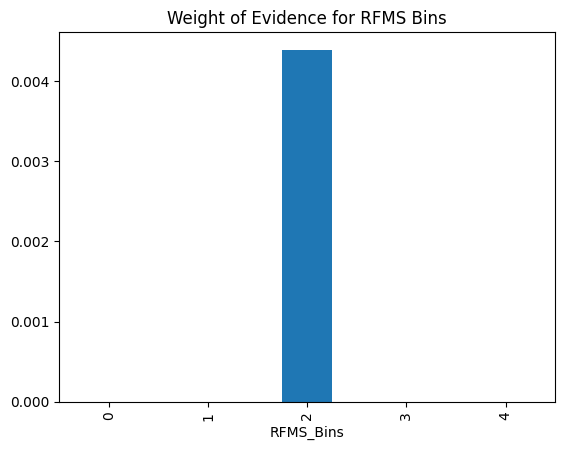

In [38]:


# Calculate WoE for each bin
grouped = RFMS.groupby('RFMS_Bins')['Risk'].value_counts(normalize=True).unstack()

# Calculate WoE (log of ratio of Good/Bad)
grouped['WoE'] = np.log(grouped['Good'] / grouped['Bad'])

# Print WoE values for each bin
print(grouped[['WoE']])

# Plot WoE values
import matplotlib.pyplot as plt
grouped['WoE'].plot(kind='bar')
plt.title('Weight of Evidence for RFMS Bins')
plt.show()


In [42]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
RFMS["Risk"] = label_encoder.fit_transform(RFMS["Risk"])
RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score,Risk,RFMS_Bins
0,5,66,1000.0,0,427.9,0,0
1,0,30895,3679.0,0,13829.6,1,4
2,81,2,500.0,0,225.1,0,0
3,5,26,20000.0,0,8011.9,1,3
4,0,30895,644.0,0,12615.6,1,4


In [40]:
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning

In [44]:
train, test = sc.split_df(RFMS, 'Risk', ratio = 0.7, seed = 999).values()

# Function to compute WOEs
var = train.drop(['Risk', 'RFMS_Bins', 'RFMS_Score'], axis = 1).columns
y_var = train['Risk']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 50, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks 
  breaks = {}
  for i in x:
    bin_object.fit(train[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks
  
woe_num(var, 'Risk')

{'Recency': [90.0],
 'Frequency': [1738.0, 4457.0, 30895.0],
 'Monetary': [4999.0, 9900.0, 10000.0, 9880000.0],
 'FraudPenalty': [0.0]}

In [53]:
data_woe=pd.read_csv("./cleaned_data.csv")
data_woe.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Unnamed: 16,Unnamed: 17
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15T02:18:49Z,2.0,0,January542024,202454March
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15T02:19:08Z,2.0,0,February33932024,202455March
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15T02:44:21Z,2.0,0,March552026,202554March
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15T03:32:55Z,2.0,0,April542027,202454March
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15T03:34:21Z,2.0,0,May542028,202554March


In [56]:
data_woe["TransactionStartTime"]=pd.to_datetime(data_woe["TransactionStartTime"])

In [57]:
from sklearn.model_selection import train_test_split
data_woe['Hour'] = pd.to_datetime(data_woe['TransactionStartTime']).dt.hour
data_woe['Day'] = pd.to_datetime(data_woe['TransactionStartTime']).dt.day
data_woe['Month'] = pd.to_datetime(data_woe['TransactionStartTime']).dt.month
y = data_woe['FraudResult']

X = data_woe[['Amount', 'Value', 'CountryCode', 'ProviderId', 'ProductId', 
        'ProductCategory', 'ChannelId', 'CurrencyCode', 'TransactionStartTime']]
X = X.drop(columns=['TransactionStartTime'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
import pandas as pd
import numpy as np

def calculate_woe(df, feature, target):
    # Create bins for the feature (using pd.cut for continuous variables)
    df['bin'] = pd.qcut(df[feature], q=5, duplicates='drop')  # 5 bins, adjust as needed

    # Calculate total Good (Non-Fraud) and Bad (Fraud) counts
    total_good = len(df[df[target] == 0])  # Non-Fraud
    total_bad = len(df[df[target] == 1])  # Fraud

    # Group by bin and calculate Good (Non-Fraud) and Bad (Fraud) counts for each bin
    grouped = df.groupby('bin').agg(
        good_count=(target, lambda x: (x == 0).sum()),  # Non-Fraud counts
        bad_count=(target, lambda x: (x == 1).sum())    # Fraud counts
    )

    # Calculate proportions for Good and Bad
    grouped['good_dist'] = grouped['good_count'] / total_good  # Proportion of Good
    grouped['bad_dist'] = grouped['bad_count'] / total_bad     # Proportion of Bad

    # Calculate WoE
    grouped['WoE'] = np.log(grouped['good_dist'] / grouped['bad_dist'])

    # Replace original feature values with WoE values
    # Map the WoE values back to the original dataframe
    woe_map = grouped['WoE'].to_dict()
    df[feature + '_woe'] = df['bin'].map(woe_map)

    # Drop temporary 'bin' column
    df.drop(columns=['bin'], inplace=True)

    return df, grouped[['good_count', 'bad_count', 'WoE']]

# Apply WoE to 'Amount' feature
df, woe_table = calculate_woe(data_woe, 'Amount', 'FraudResult')

# Display WoE table
print(woe_table)

# Now, 'Amount_woe' column has WoE transformed values for 'Amount'
print(df[['Amount', 'Amount_woe']].head())


                        good_count  bad_count       WoE
bin                                                    
(-1000000.001, -100.0]       19565          5  2.068193
(-100.0, 200.0]              18715          0       inf
(200.0, 1000.0]              23833          1  3.874960
(1000.0, 5000.0]             17322          0       inf
(5000.0, 9880000.0]          16034        187 -1.752509
    Amount  Amount_woe
0   1000.0    3.874960
1   3679.0         inf
2    500.0    3.874960
3  20000.0   -1.752509
4   -644.0    2.068193


In [71]:
data_woe.drop(columns=["CountryCode_woe"], inplace=True)

In [59]:
data_woe.drop(columns=['Unnamed: 16', 'Unnamed: 17'], inplace=True)

In [84]:
num_cols = ["int64", "float64"]
features= []
num_col=pd.DataFrame({})
for col in data_woe.columns:
    if data_woe[col].dtype.name in num_cols:  # Access the dtype of the column correctly
        features.append(col)
        num_col[col]=data_woe[col]
       
        if data_woe[col].isnull().sum() > 0:
            data_woe[col].fillna(data_woe[col].median(), inplace=True)  # Or dropna(), or any other strategy
    

In [83]:
import pandas as pd
import numpy as np

def calculate_woe(df, feature, target):
    # Create bins for the feature (using pd.cut for continuous variables)
    df['bin'] = pd.qcut(df[feature], q=5, duplicates='drop')  # 5 bins, adjust as needed

    # Calculate total Good (Non-Fraud) and Bad (Fraud) counts
    total_good = len(df[df[target] == 0])  # Non-Fraud
    total_bad = len(df[df[target] == 1])  # Fraud

    # Group by bin and calculate Good (Non-Fraud) and Bad (Fraud) counts for each bin
    grouped = df.groupby('bin').agg(
        good_count=(target, lambda x: (x == 0).sum()),  # Non-Fraud counts
        bad_count=(target, lambda x: (x == 1).sum())    # Fraud counts
    )

    # Calculate proportions for Good and Bad
    grouped['good_dist'] = grouped['good_count'] / total_good  # Proportion of Good
    grouped['bad_dist'] = grouped['bad_count'] / total_bad     # Proportion of Bad

    # Calculate WoE
    grouped['WoE'] = np.log(grouped['good_dist'] / grouped['bad_dist'])

    # Replace original feature values with WoE values
    # Map the WoE values back to the original dataframe
    woe_map = grouped['WoE'].to_dict()
    df[feature + '_woe'] = df['bin'].map(woe_map)

    # Drop temporary 'bin' column
    df.drop(columns=['bin'], inplace=True)

    return df, grouped[['good_count', 'bad_count', 'WoE']]

# Apply WoE to 'Amount' feature
df, woe_table = calculate_woe(df, 'Amount', 'FraudResult')

# Display WoE table
print(woe_table)

# Now, 'Amount_woe' column has WoE transformed values for 'Amount'
print(df[['Amount', 'Amount_woe']].head())


                        good_count  bad_count       WoE
bin                                                    
(-1000000.001, -100.0]       19565          5  2.068193
(-100.0, 200.0]              18715          0       inf
(200.0, 1000.0]              23833          1  3.874960
(1000.0, 5000.0]             17322          0       inf
(5000.0, 9880000.0]          16034        187 -1.752509
    Amount  Amount_woe
0   1000.0    3.874960
1   3679.0         inf
2    500.0    3.874960
3  20000.0   -1.752509
4   -644.0    2.068193


In [ ]:
def woebin(df, y, x, num_bins=5):
    # Create a dictionary to hold breaks for each feature
    breaks_dict = {}
    
    for feature in x:
        # Discretize the feature into bins
        discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
        df[feature + '_bin'] = discretizer.fit_transform(df[[feature]]).astype(int)
        
        # Calculate the WoE for each bin
        woe_table = df.groupby(feature + '_bin')[y].agg(
            good_count=lambda x: (x == 0).sum(),
            bad_count=lambda x: (x == 1).sum()
        )
        
        # Calculate WoE
        total_good = woe_table['good_count'].sum()
        total_bad = woe_table['bad_count'].sum()
        
        woe_table['WoE'] = np.log((woe_table['good_count'] / total_good) / (woe_table['bad_count'] / total_bad))
        
        # Store breaks in the dictionary
        breaks_dict[feature] = {
            'bins': discretizer.bin_edges_,
            'woe': woe_table['WoE']
        }
    
    return breaks_dict

# Specify the features for WoE binning
features = ['Recency', 'Frequency', 'Monetary']

# Perform WoE binning
woe_results = woebin(RFMS, 'FraudResult', features)

# Print the results
for feature, result in woe_results.items():
    print(f'WoE Binning for {feature}:')
    print(result['woe'])

In [85]:
RFMS.isnull().sum()

Recency         0
Frequency       0
Monetary        0
FraudPenalty    0
RFMS_Score      0
Risk            0
RFMS_Bins       0
dtype: int64

In [90]:
data_woe['BAD'] = np.where(data_woe['FraudResult'] == 1, 1, 0)
train, test = sc.split_df(data_woe, 'BAD', ratio = 0.7, seed = 999).values()


In [92]:
var = train.drop(['BAD', 'TransactionStartTime'], axis = 1).columns
y_var = train['BAD']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 50, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks
  breaks = {}
  for i in x:
    bin_object.fit(train[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks

In [96]:
data_woe.drop(columns=["Amount_woe","Value_woe","PricingStrategy_woe","FraudResult_woe","CountryCode_woe"])

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Hour,Day,Month,BAD
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15 02:18:49+00:00,2.0,0,2,15,11,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15 02:19:08+00:00,2.0,0,2,15,11,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15 02:44:21+00:00,2.0,0,2,15,11,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15 03:32:55+00:00,2.0,0,3,15,11,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15 03:34:21+00:00,2.0,0,3,15,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000.00000,2019-02-13 09:54:09+00:00,2.0,0,9,13,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2019-02-13 09:54:25+00:00,2.0,0,9,13,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20.00000,2019-02-13 09:54:35+00:00,2.0,0,9,13,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256.0,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000.00000,2019-02-13 10:01:10+00:00,2.0,0,10,13,2,0


In [95]:
data_woe.isnull().sum()

TransactionId               0
BatchId                     0
AccountId                   0
SubscriptionId              0
CustomerId                  0
CurrencyCode                0
CountryCode                 0
ProviderId                  0
ProductId                   0
ProductCategory             0
ChannelId                   0
Amount                      0
Value                       0
TransactionStartTime        0
PricingStrategy             0
FraudResult                 0
Hour                        0
Day                         0
Month                       0
Amount_woe                  0
Value_woe                   0
PricingStrategy_woe         0
FraudResult_woe             0
CountryCode_woe         95662
BAD                         0
dtype: int64

In [3]:
data_clean=pd.read_csv("./cleaned_data.csv")
data_clean.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Unnamed: 16,Unnamed: 17
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15T02:18:49Z,2.0,0,January542024,202454March
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15T02:19:08Z,2.0,0,February33932024,202455March
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15T02:44:21Z,2.0,0,March552026,202554March
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15T03:32:55Z,2.0,0,April542027,202454March
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15T03:34:21Z,2.0,0,May542028,202554March


In [4]:
data_clean.drop(columns=["Unnamed: 16","Unnamed: 17"],inplace=True)


In [101]:
data_clean.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15T02:18:49Z,2.0,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15T02:19:08Z,2.0,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15T02:44:21Z,2.0,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15T03:32:55Z,2.0,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15T03:34:21Z,2.0,0


In [9]:
data_clean["TransactionStartTime"]=pd.to_datetime(data_clean["TransactionStartTime"])

In [10]:
data_clean["hour"]=data_clean["TransactionStartTime"].dt.hour
data_clean["day"]=data_clean["TransactionStartTime"].dt.day
data_clean["month"]=data_clean["TransactionStartTime"].dt.month
data_clean["year"]=data_clean["TransactionStartTime"].dt.year
data_clean.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,hour,day,month,year
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15 02:18:49+00:00,2.0,0,2,15,11,2018
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15 02:19:08+00:00,2.0,0,2,15,11,2018
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15 02:44:21+00:00,2.0,0,2,15,11,2018
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15 03:32:55+00:00,2.0,0,3,15,11,2018
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15 03:34:21+00:00,2.0,0,3,15,11,2018


In [11]:
import scorecardpy as sc
train, test = sc.split_df(data_clean, 'FraudResult', ratio = 0.7, seed = 999).values()

In [13]:
var = train.drop(["TransactionId","FraudResult","BatchId","AccountId","SubscriptionId","CustomerId","CurrencyCode","ProviderId","ProductId","ProductCategory","ChannelId","TransactionStartTime"], axis = 1).columns
y_var = train['FraudResult']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 50, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks
  breaks = {}
  for i in x:
    bin_object.fit(train[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks


In [15]:
from monotonic_binning.monotonic_woe_binning import Binning
unique_values = data_clean.nunique()

print(unique_values)

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1677
Value                    1518
TransactionStartTime    94555
PricingStrategy             5
FraudResult                 2
hour                       24
day                        31
month                       4
year                        2
dtype: int64


In [16]:
woe_num(var, 'FraudResult')

{'CountryCode': [256.0],
 'Amount': [490000.0, 9880000.0],
 'Value': [490000.0, 9880000.0],
 'PricingStrategy': [4.0],
 'hour': [11.0, 20.0, 23.0],
 'day': [31.0],
 'month': [12.0],
 'year': [2018.0, 2019.0]}

In [28]:
import pandas as pd
import scorecardpy as sc

# Ensure the relevant columns are categorical

train['CurrencyCode'] = train['CurrencyCode'].astype('category')
train['ProviderId'] = train['ProviderId'].astype('category')
train['ProductId'] = train['ProductId'].astype('category')
train['ProductCategory'] = train['ProductCategory'].astype('category')
train['ChannelId'] = train['ChannelId'].astype('category')

# Drop rows with missing values in the specified columns
train = train.dropna(subset=[ "CurrencyCode", "ProviderId", "ProductId", "ProductCategory", "ChannelId"])

# Perform WOE binning
bins = sc.woebin(train, y='FraudResult', x=["CurrencyCode", "ProviderId", "ProductId", "ProductCategory", "ChannelId"], save_breaks_list='cat_breaks')


[INFO] creating woe binning ...
[INFO] The breaks_list is saved as cat_breaks_20241007_112332.py


In [29]:
# import dictionary
from cat_breaks_20241006_162107 import breaks_list    
breaks_list

# merge
breaks.update(breaks_list)
print(breaks)

{'CountryCode': [256.0], 'Amount': [490000.0, 9880000.0], 'Value': [490000.0, 9880000.0], 'PricingStrategy': [4.0], 'hour': [11.0, 20.0, 23.0], 'day': [31.0], 'month': [12.0], 'year': [2018.0, 2019.0], 'ChannelId': ['ChannelId_1%,%ChannelId_2', 'ChannelId_3%,%ChannelId_5'], 'ProductCategory': ['airtime%,%data_bundles', 'financial_services%,%movies%,%other%,%ticket%,%transport%,%tv%,%utility_bill'], 'ProductId': ['ProductId_1%,%ProductId_10', 'ProductId_11%,%ProductId_12%,%ProductId_13%,%ProductId_14%,%ProductId_15%,%ProductId_16%,%ProductId_19%,%ProductId_2%,%ProductId_20%,%ProductId_21%,%ProductId_22%,%ProductId_23%,%ProductId_24%,%ProductId_27', 'ProductId_3%,%ProductId_4%,%ProductId_5', 'ProductId_6%,%ProductId_7%,%ProductId_8%,%ProductId_9'], 'ProviderId': ['ProviderId_1%,%ProviderId_2%,%ProviderId_3', 'ProviderId_4', 'ProviderId_5', 'ProviderId_6']}


In [36]:
import pandas as pd
import scorecardpy as sc
# List of columns to drop
columns_to_drop = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'TransactionStartTime']

# Drop the identified columns from the dataset
data_clean1 = data_clean.drop(columns=columns_to_drop)


data_clean1['FraudResult'] = data_clean['FraudResult'].replace({'GOOD': 0, 'BAD': 1})

positive_class = '1' 


bins_adj = sc.woebin(
    data_clean1, 
    y='FraudResult', 
    breaks_list=breaks,  
    positive=positive_class
)


print(bins_adj)


[INFO] creating woe binning ...
{'hour':   variable          bin  count  count_distr   good  bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0     hour  [-inf,11.0)  35952     0.375823  35900   52  0.001446 -0.338035  0.036460  0.126432   11.0              False
1     hour  [11.0,20.0)  54238     0.566975  54125  113  0.002083  0.027551  0.000436  0.126432   20.0              False
2     hour  [20.0,23.0)   5188     0.054233   5160   28  0.005397  0.982727  0.088795  0.126432   23.0              False
3     hour   [23.0,inf)    284     0.002969    284    0  0.000000  0.444880  0.000742  0.126432    inf              False, 'ProviderId':      variable                                         bin  count  count_distr   good  bad   badprob       woe    bin_iv  total_iv                                      breaks  is_special_values
0  ProviderId  ProviderId_1%,%ProviderId_2%,%ProviderId_3   8744     0.091405   8623  121  0.013838  1.937469  1.039686  3.278704  ProviderId

{'hour': <Figure size 640x480 with 2 Axes>,
 'ProviderId': <Figure size 640x480 with 2 Axes>,
 'Value': <Figure size 640x480 with 2 Axes>,
 'PricingStrategy': <Figure size 640x480 with 2 Axes>,
 'ProductId': <Figure size 640x480 with 2 Axes>,
 'month': <Figure size 640x480 with 2 Axes>,
 'year': <Figure size 640x480 with 2 Axes>,
 'ProductCategory': <Figure size 640x480 with 2 Axes>,
 'Amount': <Figure size 640x480 with 2 Axes>,
 'day': <Figure size 640x480 with 2 Axes>,
 'ChannelId': <Figure size 640x480 with 2 Axes>}

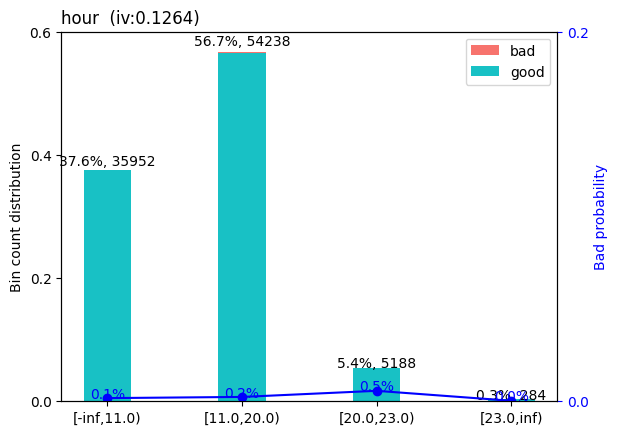

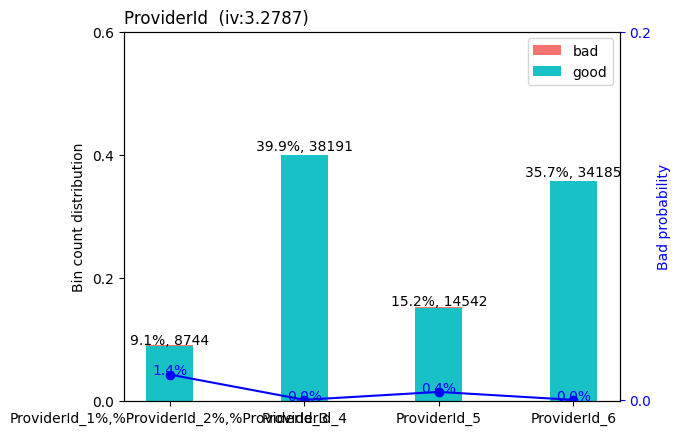

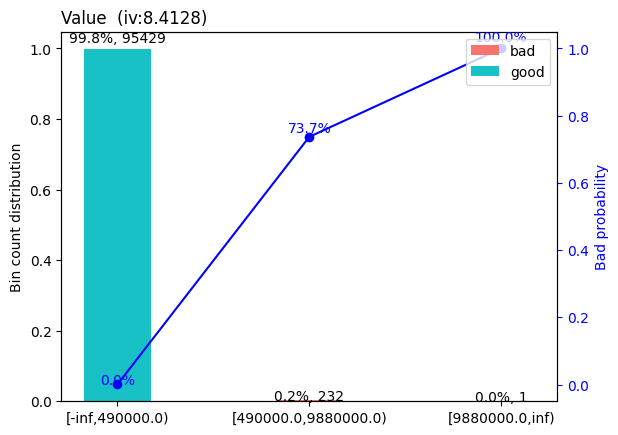

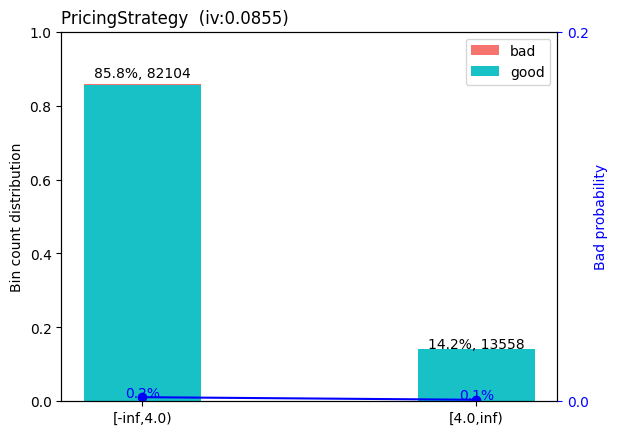

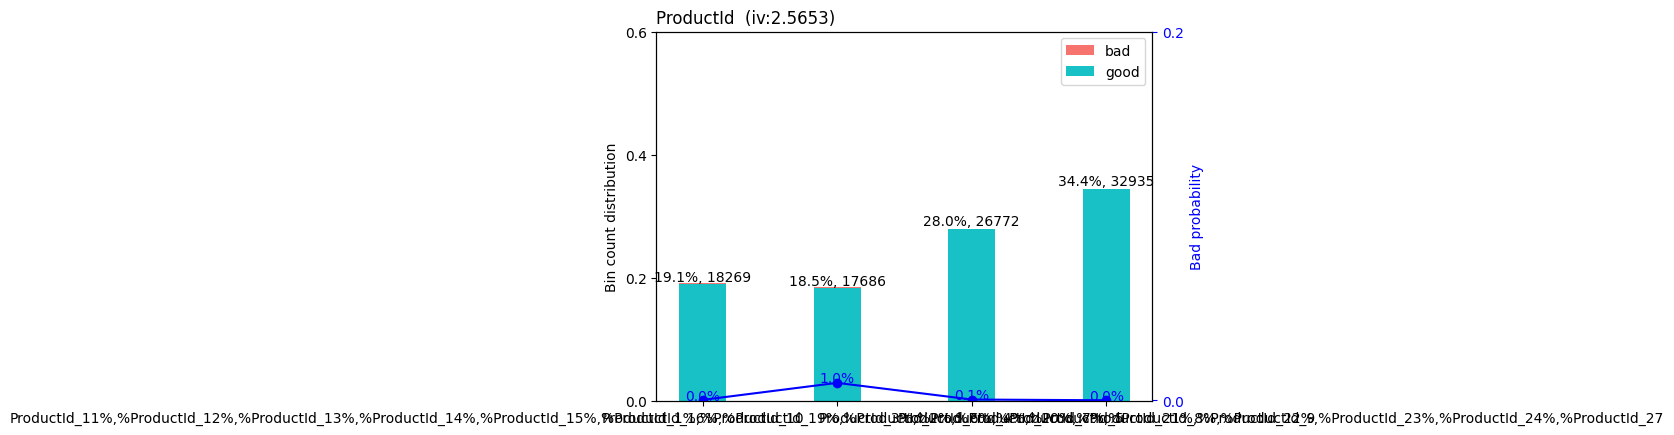

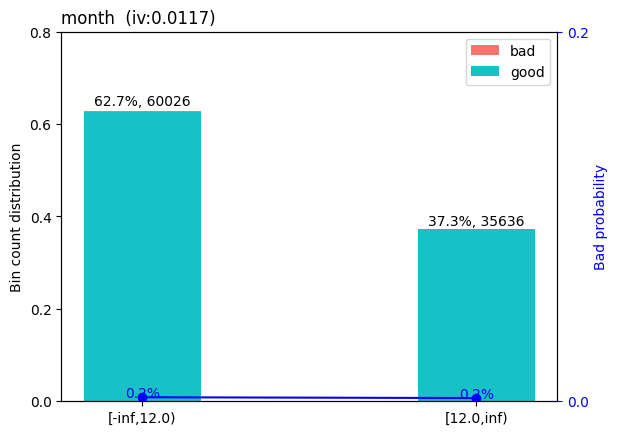

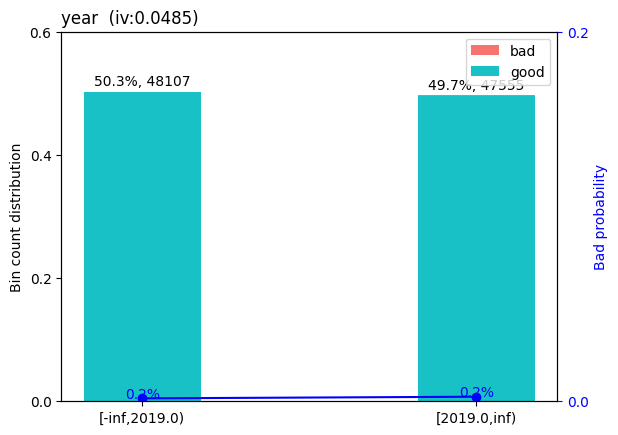

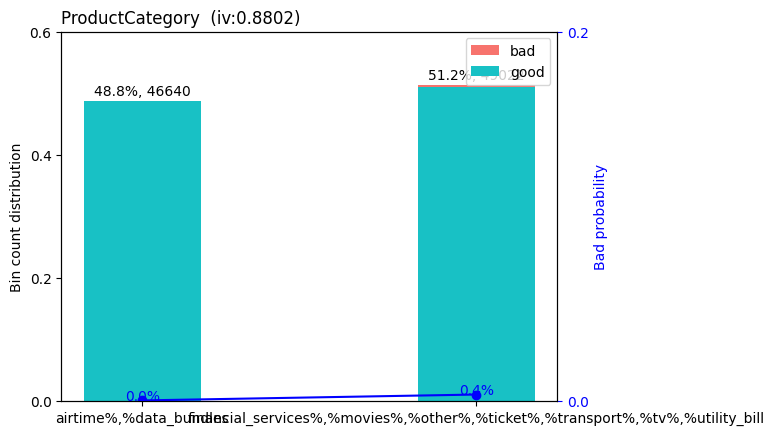

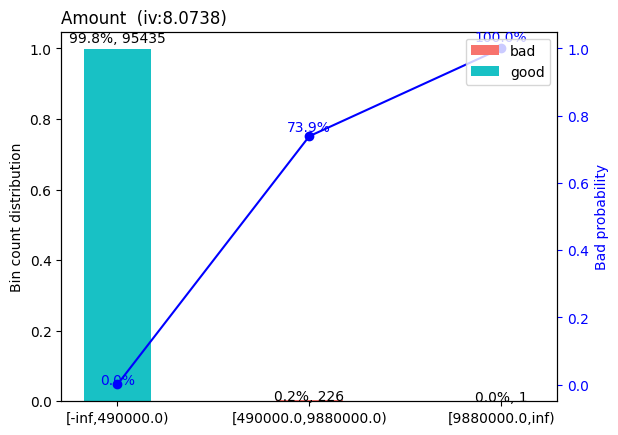

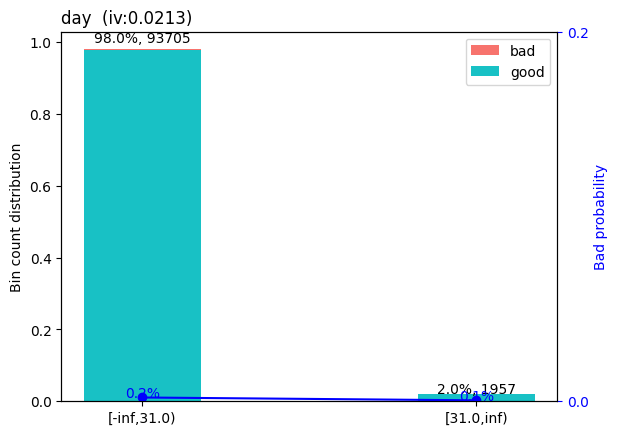

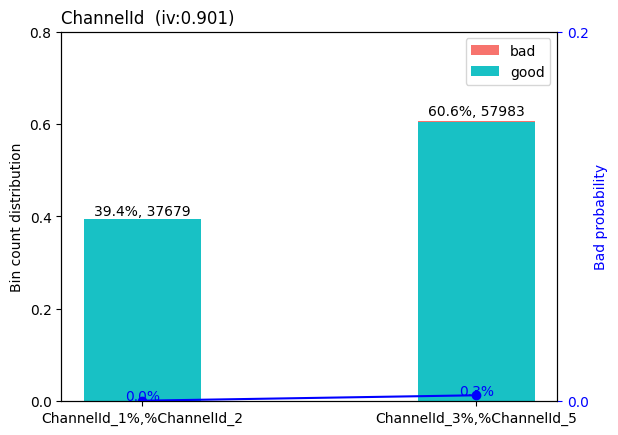

In [37]:
sc.woebin_plot(bins_adj)

In [39]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [40]:
# Merge by index
train_final = train.merge(train_woe, how = 'left', left_index=True, right_index=True)
test_final = test.merge(test_woe, how = 'left', left_index=True, right_index=True)

In [41]:
train_final.head(10)

,TransactionId_x,BatchId_x,AccountId_x,SubscriptionId_x,CustomerId_x,CurrencyCode_x,CountryCode_x,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime_x,PricingStrategy,FraudResult_x,hour,day,month,year,BatchId_y,TransactionId_y,FraudResult_y,TransactionStartTime_y,SubscriptionId_y,CustomerId_y,CurrencyCode_y,AccountId_y,CountryCode_y,hour_woe,ProviderId_woe,Value_woe,PricingStrategy_woe,ProductId_woe,month_woe,year_woe,ProductCategory_woe,Amount_woe,day_woe,ChannelId_woe
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15 02:18:49+00:00,2.0,0,2,15,11,2018,BatchId_36123,TransactionId_76871,0,2018-11-15 02:18:49+00:00,SubscriptionId_887,CustomerId_4406,UGX,AccountId_3957,256.0,-0.338035,-3.136976,-2.217519,0.094351,-1.817006,0.078716,-0.245002,-1.655589,-2.043187,0.015506,0.454076
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15 02:19:08+00:00,2.0,0,2,15,11,2018,BatchId_15642,TransactionId_73770,0,2018-11-15 02:19:08+00:00,SubscriptionId_3829,CustomerId_4406,UGX,AccountId_4841,256.0,-0.338035,-2.736920,-2.217519,0.094351,-2.812009,0.078716,-0.245002,0.572204,-2.043187,0.015506,-2.135528
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15 03:34:21+00:00,2.0,0,3,15,11,2018,BatchId_38780,TransactionId_28195,0,2018-11-15 03:34:21+00:00,SubscriptionId_3829,CustomerId_988,UGX,AccountId_4841,256.0,-0.338035,-2.736920,-2.217519,0.094351,-2.812009,0.078716,-0.245002,0.572204,-2.043187,0.015506,-2.135528
5,TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256.0,ProviderId_6,ProductId_3,airtime,ChannelId_3,3679.0,9900.64041,2018-11-15 03:35:10+00:00,2.0,0,3,15,11,2018,BatchId_25954,TransactionId_23223,0,2018-11-15 03:35:10+00:00,SubscriptionId_4238,CustomerId_1432,UGX,AccountId_1078,256.0,-0.338035,-3.136976,-2.217519,0.094351,-1.351665,0.078716,-0.245002,-1.655589,-2.043187,0.015506,0.454076
8,TransactionId_51905,BatchId_93774,AccountId_272,SubscriptionId_4731,CustomerId_598,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,3679.0,500.00000,2018-11-15 04:14:59+00:00,2.0,0,4,15,11,2018,BatchId_93774,TransactionId_51905,0,2018-11-15 04:14:59+00:00,SubscriptionId_4731,CustomerId_598,UGX,AccountId_272,256.0,-0.338035,-3.136976,-2.217519,0.094351,-1.817006,0.078716,-0.245002,-1.655589,-2.043187,0.015506,0.454076
9,TransactionId_130161,BatchId_82409,AccountId_710,SubscriptionId_920,CustomerId_1053,UGX,256.0,ProviderId_1,ProductId_15,financial_services,ChannelId_3,600.0,600.00000,2018-11-15 04:31:48+00:00,2.0,0,4,15,11,2018,BatchId_82409,TransactionId_130161,0,2018-11-15 04:31:48+00:00,SubscriptionId_920,CustomerId_1053,UGX,AccountId_710,256.0,-0.338035,1.937469,-2.217519,0.094351,1.562838,0.078716,-0.245002,0.572204,-2.043187,0.015506,0.454076
11,TransactionId_33857,BatchId_126394,AccountId_4841,SubscriptionId_3829,CustomerId_3052,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,40.00000,2018-11-15 04:32:42+00:00,2.0,0,4,15,11,2018,BatchId_126394,TransactionId_33857,0,2018-11-15 04:32:42+00:00,SubscriptionId_3829,CustomerId_3052,UGX,AccountId_4841,256.0,-0.338035,-2.736920,-2.217519,0.094351,-2.812009,0.078716,-0.245002,0.572204,-2.043187,0.015506,-2.135528
12,TransactionId_94963,BatchId_104726,AccountId_710,SubscriptionId_920,CustomerId_1053,UGX,256.0,ProviderId_1,ProductId_15,financial_services,ChannelId_3,600.0,600.00000,2018-11-15 04:35:10+00:00,2.0,0,4,15,11,2018,BatchId_104726,TransactionId_94963,0,2018-11-15 04:35:10+00:00,SubscriptionId_920,CustomerId_1053,UGX,AccountId_710,256.0,-0.338035,1.937469,-2.217519,0.094351,1.562838,0.078716,-0.245002,0.572204,-2.043187,0.0155

In [43]:
train_final = train_final.drop(columns = 'FraudResult_y').rename(columns={'FraudResult_x':'vd'})
test_final = test_final.drop(columns = 'FraudResult_y').rename(columns={'FraudResult_x':'vd'})

In [46]:
train_final.head()

,TransactionId_x,BatchId_x,AccountId_x,SubscriptionId_x,CustomerId_x,CurrencyCode_x,CountryCode_x,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime_x,PricingStrategy,vd,hour,day,month,year,BatchId_y,TransactionId_y,TransactionStartTime_y,SubscriptionId_y,CustomerId_y,CurrencyCode_y,AccountId_y,CountryCode_y,hour_woe,ProviderId_woe,Value_woe,PricingStrategy_woe,ProductId_woe,month_woe,year_woe,ProductCategory_woe,Amount_woe,day_woe,ChannelId_woe
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15 02:18:49+00:00,2.0,0,2,15,11,2018,BatchId_36123,TransactionId_76871,2018-11-15 02:18:49+00:00,SubscriptionId_887,CustomerId_4406,UGX,AccountId_3957,256.0,-0.338035,-3.136976,-2.217519,0.094351,-1.817006,0.078716,-0.245002,-1.655589,-2.043187,0.015506,0.454076
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15 02:19:08+00:00,2.0,0,2,15,11,2018,BatchId_15642,TransactionId_73770,2018-11-15 02:19:08+00:00,SubscriptionId_3829,CustomerId_4406,UGX,AccountId_4841,256.0,-0.338035,-2.736920,-2.217519,0.094351,-2.812009,0.078716,-0.245002,0.572204,-2.043187,0.015506,-2.135528
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15 03:34:21+00:00,2.0,0,3,15,11,2018,BatchId_38780,TransactionId_28195,2018-11-15 03:34:21+00:00,SubscriptionId_3829,CustomerId_988,UGX,AccountId_4841,256.0,-0.338035,-2.736920,-2.217519,0.094351,-2.812009,0.078716,-0.245002,0.572204,-2.043187,0.015506,-2.135528
5,TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256.0,ProviderId_6,ProductId_3,airtime,ChannelId_3,3679.0,9900.64041,2018-11-15 03:35:10+00:00,2.0,0,3,15,11,2018,BatchId_25954,TransactionId_23223,2018-11-15 03:35:10+00:00,SubscriptionId_4238,CustomerId_1432,UGX,AccountId_1078,256.0,-0.338035,-3.136976,-2.217519,0.094351,-1.351665,0.078716,-0.245002,-1.655589,-2.043187,0.015506,0.454076
8,TransactionId_51905,BatchId_93774,AccountId_272,SubscriptionId_4731,CustomerId_598,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,3679.0,500.00000,2018-11-15 04:14:59+00:00,2.0,0,4,15,11,2018,BatchId_93774,TransactionId_51905,2018-11-15 04:14:59+00:00,SubscriptionId_4731,CustomerId_598,UGX,AccountId_272,256.0,-0.338035,-3.136976,-2.217519,0.094351,-1.817006,0.078716,-0.245002,-1.655589,-2.043187,0.015506,0.454076


In [53]:
train_final = train_final.drop(train_final.select_dtypes(include=['category',"object"]).columns, axis=1)

In [54]:
train_final = train_final.drop(train_final.select_dtypes(include=['datetime64']).columns, axis=1)

In [56]:
sc.iv(train_final, y = 'vd')

,variable,info_value
11,Value_woe,8.037206
17,Amount_woe,7.828734
0,Value,6.859466
5,Amount,6.710984
1,ProviderId_woe,3.591470
13,ProductId_woe,2.696362
7,ChannelId_woe,1.011781
4,ProductCategory_woe,0.865570
15,PricingStrategy,0.748569
6,day,0.681186


In [57]:
sc.var_filter(train_final, y = 'vd')

[INFO] filtering variables ...
Variable filtering on 66963 rows and 23 columns in 00:01:34 
8 variables are removed


,Value,ProviderId_woe,month,year_woe,ProductCategory_woe,Amount,day,ChannelId_woe,hour,ProductId_woe,PricingStrategy,PricingStrategy_woe,year,hour_woe,vd
0,1000.00000,-3.136976,11,-0.245002,-1.655589,1000.0,15,0.454076,2,-1.817006,2.0,0.094351,2018,-0.338035,0
1,20.00000,-2.736920,11,-0.245002,0.572204,3679.0,15,-2.135528,2,-2.812009,2.0,0.094351,2018,-0.338035,0
4,644.00000,-2.736920,11,-0.245002,0.572204,-644.0,15,-2.135528,3,-2.812009,2.0,0.094351,2018,-0.338035,0
5,9900.64041,-3.136976,11,-0.245002,-1.655589,3679.0,15,0.454076,3,-1.351665,2.0,0.094351,2018,-0.338035,0
8,500.00000,-3.136976,11,-0.245002,-1.655589,3679.0,15,0.454076,4,-1.817006,2.0,0.094351,2018,-0.338035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95656,50000.00000,-3.136976,2,0.198862,-1.655589,50000.0,13,0.454076,9,-1.817006,2.0,0.094351,2019,-0.338035,0
95658,1000.00000,-3.136976,2,0.198862,-1.655589,1000.0,13,0.454076,9,-1.817006,2.0,0.094351,2019,-0.338035,0
95659,20.00000,-2.736920,2,0.198862,0.572204,-20.0,13,-2.135528,9,-2.812009,2.0,0.094351,2019,-0.338035,0
95660,3000.00000,-3.136976,2,0.198862,0.572204,3000.0,13,0.454076,10,1.562838,2.0,0.094351,2019,-0.338035,0


In [51]:
train.dtypes

CountryCode                         float64
Amount                              float64
Value                               float64
TransactionStartTime    datetime64[ns, UTC]
PricingStrategy                     float64
FraudResult                           int64
hour                                  int32
day                                   int32
month                                 int32
year                                  int32
dtype: object